Lý do lọc bỏ

A. Xử lý Area_m2 (Diện tích)

- Ngưỡng dưới (< 10m²)
    Các bất động sản có diện tích dưới 10m² tại TP.HCM hầu như không xuất hiện trên các nền tảng giao dịch uy tín. Phần lớn các bản ghi này là tin rác, phòng trọ hoặc lỗi nhập liệu, do đó được loại bỏ.

- Ngưỡng trên (> 1000m²)
    Với phạm vi nghiên cứu tập trung vào nhà ở, các bất động sản có diện tích vượt quá 500–1000m² thường là đất dự án hoặc bất động sản đặc thù. Các giá trị này gây nhiễu cho quá trình phân tích phân khúc giá nên được loại bỏ.

B. Xử lý Width_m (Chiều rộng mặt tiền)

- Nhà có chiều ngang < 1.5m là không khả thi về mặt sử dụng thực tế hoặc do lỗi nhập liệu.

- Nhà có chiều ngang > 50m thường thuộc nhóm biệt thự đặc biệt hoặc đất công nghiệp, không phù hợp với đối tượng nghiên cứu.

C. Xử lý Floors, Bedrooms, Toilets

- Floors > 10 tầng
    Thường là cao ốc văn phòng hoặc chung cư mini, không đại diện cho nhà ở riêng lẻ.

- Bedrooms / Toilets = 0
    Không phù hợp với giả định nhà xây sẵn, nhiều khả năng là dữ liệu thiếu hoặc sai.

- Bedrooms / Toilets > 20
    Với diện tích nhà ở thông thường, giá trị này là bất hợp lý và được xem là ngoại lai.

D. Kiểm tra Logic (Area_m2 / Bedrooms)

- Tỷ lệ Diện tích / Số phòng ngủ < 5m²/phòng là không khả thi về mặt sinh hoạt (không đủ không gian cho phòng ngủ).

- Các bản ghi vi phạm điều kiện này được xem là dữ liệu không hợp lệ.

E. Lọc giá/m² quá thấp

- Các bất động sản có giá/m² < 10 triệu VNĐ thường là:

- Tin rác

- Giá nhập sai đơn vị

- Bất động sản không đúng bản chất nhà ở

Việc loại bỏ giúp phân phối giá ổn định hơn và hỗ trợ tốt cho các thuật toán phân cụm.

In [6]:
import pandas as pd
import numpy as np
import os

INPUT_FILE = "../data/cleaned/Done-p3.csv"
OUTPUT_FILE = "../data/cleaned/Done-p3-clean-logic.csv"

def clean_and_filter_data():
    if not os.path.exists(INPUT_FILE):
        print(f"File not found: {INPUT_FILE}")
        return

    print(f"Reading {INPUT_FILE}...")
    try:
        df = pd.read_csv(INPUT_FILE)
        initial_count = len(df)
        print(f"Initial rows: {initial_count}")

        # Helper: find column regardless of case
        def get_col(name):
            return next((c for c in df.columns if name.lower() in c.lower()), None)

        col_area = get_col('area')
        col_width = get_col('width')
        col_floors = get_col('floor')
        col_bed = get_col('bed')
        col_toilet = get_col('toilet') or get_col('bath')
        col_price_per = get_col('price_per')

        print("Detected columns:")
        print(f"Area={col_area}, Width={col_width}, Floors={col_floors}, "
              f"Bedrooms={col_bed}, Toilets={col_toilet}, Price_per={col_price_per}")

        # Convert numeric columns
        numeric_cols = [c for c in [
            col_area, col_width, col_floors, col_bed, col_toilet, col_price_per
        ] if c]

        for c in numeric_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')

        # =========================
        # A. Area_m2
        # =========================
        if col_area:
            mask_area = (df[col_area] < 10) | (df[col_area] > 1000)
            print(f"Dropped {mask_area.sum()} rows (Area < 10 or > 1000 m2).")
            df = df[~mask_area]

        # =========================
        # B. Width_m
        # =========================
        if col_width:
            mask_width = (df[col_width] < 1.5) | (df[col_width] > 50)
            print(f"Dropped {mask_width.sum()} rows (Width < 1.5 or > 50 m).")
            df = df[~mask_width]

        # =========================
        # C. Floors / Bedrooms / Toilets
        # =========================
        if col_floors:
            mask_floors = df[col_floors] > 10
            print(f"Dropped {mask_floors.sum()} rows (Floors > 10).")
            df = df[~mask_floors]

        if col_bed:
            mask_bed = (df[col_bed] == 0) | (df[col_bed] > 20)
            print(f"Dropped {mask_bed.sum()} rows (Bedrooms = 0 or > 20).")
            df = df[~mask_bed]

        if col_toilet:
            mask_toilet = (df[col_toilet] == 0) | (df[col_toilet] > 20)
            print(f"Dropped {mask_toilet.sum()} rows (Toilets = 0 or > 20).")
            df = df[~mask_toilet]

        # =========================
        # D. Logic check: Area / Bedroom
        # =========================
        if col_area and col_bed:
            ratio = df[col_area] / df[col_bed]
            mask_logic = ratio < 5
            print(f"Dropped {mask_logic.sum()} rows (Area/Bedroom < 5 m2).")
            df = df[~mask_logic]

        # =========================
        # E. Remove low price_per_m2
        # =========================
        if col_price_per:
            mask_price = df[col_price_per] < 10
            print(f"Dropped {mask_price.sum()} rows (Price_per_m2 < 10).")
            df = df[~mask_price]

        final_count = len(df)
        print("\n=== SUMMARY ===")
        print(f"Final rows: {final_count}")
        print(f"Total dropped: {initial_count - final_count}")

        df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
        print(f"Saved cleaned data to: {OUTPUT_FILE}")

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    clean_and_filter_data()


Reading ../data/cleaned/Done-p3.csv...
Initial rows: 20817
Detected columns:
Area=Area_m2, Width=Width_m, Floors=Floors, Bedrooms=Bedrooms, Toilets=Toilets, Price_per=Price_Per_m2
Dropped 187 rows (Area < 10 or > 1000 m2).
Dropped 110 rows (Width < 1.5 or > 50 m).
Dropped 32 rows (Floors > 10).
Dropped 298 rows (Bedrooms = 0 or > 20).
Dropped 64 rows (Toilets = 0 or > 20).
Dropped 70 rows (Area/Bedroom < 5 m2).
Dropped 93 rows (Price_per_m2 < 10).

=== SUMMARY ===
Final rows: 19963
Total dropped: 854
Saved cleaned data to: ../data/cleaned/Done-p3-clean-logic.csv


Columns: ['Price_Billion', 'Price_Per_m2', 'Area_m2', 'District', 'Ward', 'Bedrooms', 'Is_MatTien', 'Width_m', 'Floors', 'Is Hem', 'Post Time', 'Toilets']
Dang ve bieu do: Price_Per_m2 theo District


D:\Temp\ipykernel_65808\3232347932.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col_dist, y=col_price, data=df, order=sorted_index, palette="Set3")


Boxplot saved to: ../reports/boxplot_price_per_m2_check_after.png


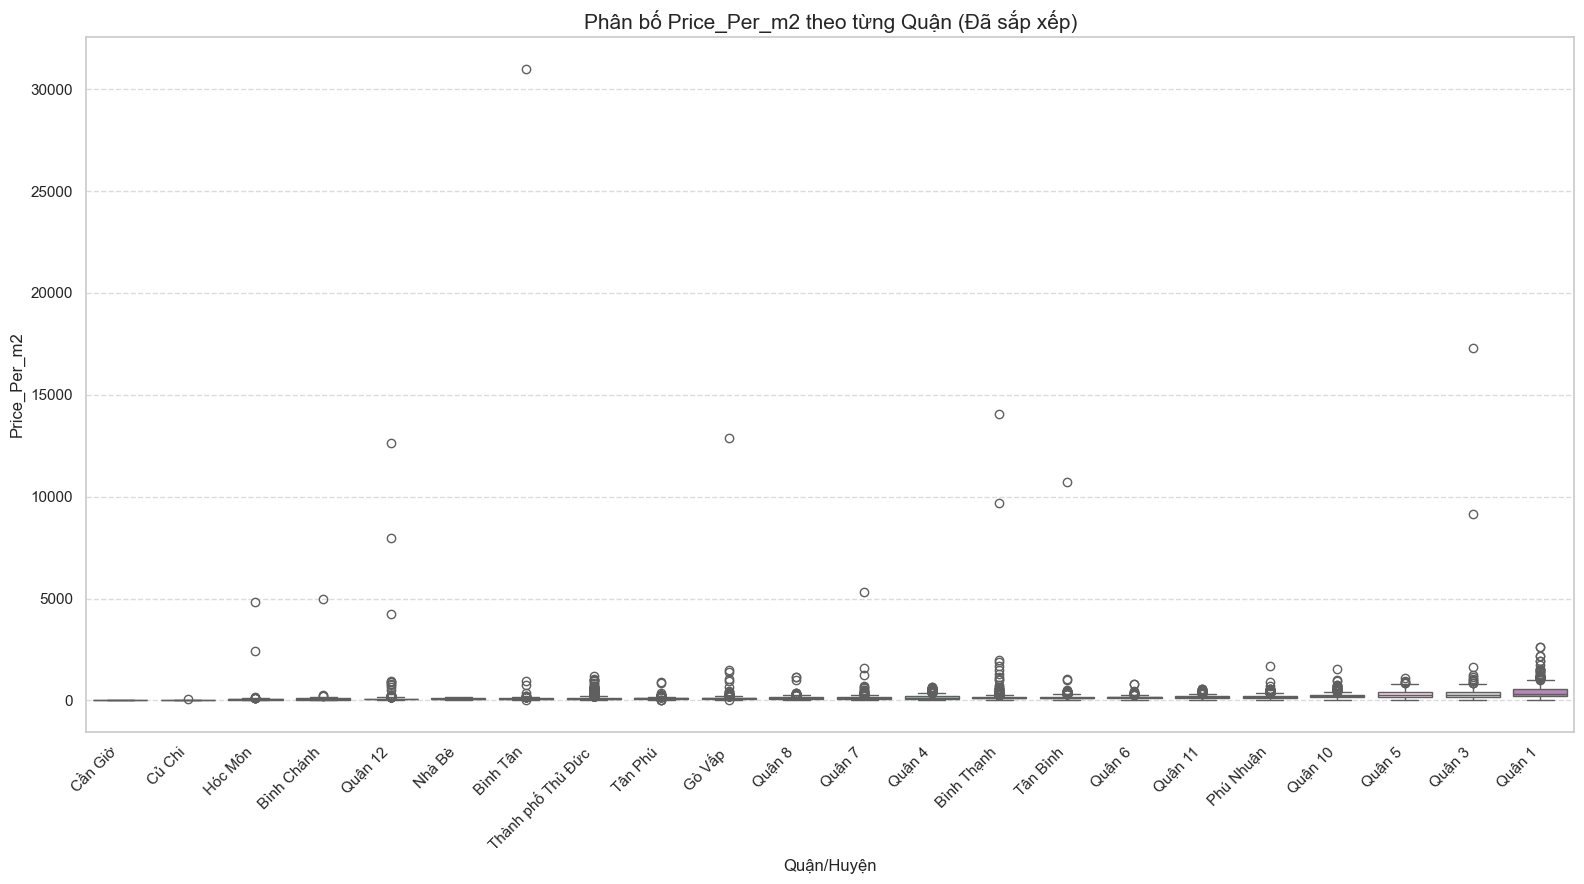

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# File Path
FILE_PATH = '../data/cleaned/Done-p3-clean-logic.csv'
# Đổi tên file ảnh output để không bị đè lên ảnh cũ, dễ so sánh
OUTPUT_IMG = '../reports/boxplot_price_per_m2_check_after.png'

def plot_boxplot():
    if not os.path.exists(FILE_PATH):
        print(f"File not found: {FILE_PATH}")
        return

    try:
        # Read Data
        df = pd.read_csv(FILE_PATH)
        print("Columns:", df.columns.tolist())

        # 1. Identify District Column
        col_dist = next((c for c in df.columns if 'district' in c.lower() or 'quan' in c.lower() or 'quận' in c.lower()), None)

        # 2. Identify Price Column - Ưu tiên Price_Per_m2 để check ngoại lai
        # Tìm cột có chữ 'per_m2', 'm2' trong tên giá
        col_price = next((c for c in df.columns if 'price_per' in c.lower() or ('gia' in c.lower() and 'm2' in c.lower())), None)

        # Nếu không có cột m2 mới dùng cột Price_Billion
        if not col_price:
            print("Không tìm thấy cột Price_Per_m2, đang dùng cột Price_Billion...")
            col_price = next((c for c in df.columns if 'price_billion' in c.lower() or 'price_ty' in c.lower()), None)

        if not col_dist or not col_price:
            print(f"Could not identify District ('{col_dist}') or Price ('{col_price}') columns.")
            return

        print(f"Dang ve bieu do: {col_price} theo {col_dist}")

        # Preprocessing
        # Ensure Price is numeric
        df[col_price] = pd.to_numeric(df[col_price], errors='coerce')
        df = df.dropna(subset=[col_price, col_dist])

        # Sắp xếp thứ tự Quận theo giá trung vị (Median) tăng dần để biểu đồ đẹp hơn
        sorted_index = df.groupby(col_dist)[col_price].median().sort_values().index

        # Setup Plot
        plt.figure(figsize=(16, 9)) # Tăng kích thước xíu cho dễ nhìn

        # Vẽ Boxplot với thứ tự đã sắp xếp
        sns.boxplot(x=col_dist, y=col_price, data=df, order=sorted_index, palette="Set3")

        plt.xticks(rotation=45, ha='right')
        plt.title(f'Phân bố {col_price} theo từng Quận (Đã sắp xếp)', fontsize=15)
        plt.ylabel(col_price, fontsize=12)
        plt.xlabel('Quận/Huyện', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7) # Thêm lưới ngang cho dễ dóng
        plt.tight_layout()

        # Save
        plt.savefig(OUTPUT_IMG)
        print(f"Boxplot saved to: {OUTPUT_IMG}")

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    plot_boxplot()

Sau khi phân thích ta thấy xuất hiện quá nhiều ngoại lai giá trên trời

Tại sao lại dùng phương pháp IQR?

Cơ chế:
Nó tập trung vào 50% dữ liệu ở giữa (từ Q1 - 25% đến Q3 - 75%). Đây là vùng giá trị đại diện cho thị trường "thật"
.Khoảng cách $IQR = Q3 - Q1$.Bất kỳ giá trị nào vượt quá $1.5 \times IQR$ so với vùng giữa này được coi là bất thường
(quá rẻ hoặc quá đắt một cách vô lý so với mặt bằng chung).
Lợi ích: Nó loại bỏ các giá trị gây nhiễu (noise) mà không cần bạn phải đoán mò con số cụ thể (ví dụ: không cần quy định cứng "trên 100 tỷ là xóa").

Tại sao phải gom nhóm theo Quận (groupby('District'))?

- Tính địa phương (Locality): Giá bất động sản phụ thuộc cực lớn vào vị trí.

    Ví dụ: Đơn giá 500 triệu/m2 là bình thường ở Quận 1 (Trung tâm), nhưng là phi lý/ngoại lai ở Huyện Củ Chi (Ngoại ô).

- Nếu không gom nhóm (Global Filtering): Nếu bạn áp dụng IQR cho toàn bộ TP.HCM chung một lúc, thuật toán sẽ coi tất cả nhà ở Quận 1 là ngoại lai (vì giá cao hơn hẳn trung bình thành phố) và xóa sạch dữ liệu "xịn" này.

- Giải pháp trong code: Dòng group_df = df[df[group_col] == dist] đảm bảo rằng việc xét "đắt hay rẻ" được so sánh cục bộ trong chính quận đó. Nhà Quận 1 so với nhà Quận 1, nhà Củ Chi so với nhà Củ Chi.

Tại sao lọc trên Price_Per_m2 chứ không phải Price_Billion?

- Chuẩn hóa: Tổng giá (Price_Billion) chịu ảnh hưởng bởi Diện tích. Một căn biệt thự 1000m2 giá 200 tỷ là hợp lý. Nhưng một căn nhà 50m2 giá 200 tỷ là vô lý.

- Phản ánh đúng bản chất: Trong định giá bất động sản, đơn giá/m2 là thước đo chuẩn xác nhất để đánh giá phân khúc và phát hiện bất thường.

In [8]:
import pandas as pd
import numpy as np

INPUT_FILE = '../data/cleaned/Done-p3-clean-logic.csv'
OUTPUT_FILE = '../data/cleaned/Done-EDA.csv'

def remove_outliers_iqr_by_group(df, group_col, value_col):
    """
    Lọc ngoại lai theo phương pháp IQR cho từng nhóm (Quận)
    """
    df_cleaned = pd.DataFrame()

    # Lấy danh sách các quận
    districts = df[group_col].unique()

    print(f"Bắt đầu lọc ngoại lai cho {len(districts)} khu vực dựa trên {value_col}...")

    for dist in districts:
        # Lấy dữ liệu của từng quận
        group_df = df[df[group_col] == dist].copy()

        # Bỏ qua nếu dữ liệu quận quá ít để tính toán thống kê
        if len(group_df) < 10:
            df_cleaned = pd.concat([df_cleaned, group_df])
            continue

        Q1 = group_df[value_col].quantile(0.25)
        Q3 = group_df[value_col].quantile(0.75)
        IQR = Q3 - Q1

        # Xác định biên (nới lỏng 1.5 hoặc chặt hơn là 1.0 tùy bạn)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Lọc dữ liệu trong biên
        valid_rows = group_df[(group_df[value_col] >= lower_bound) & (group_df[value_col] <= upper_bound)]
        df_cleaned = pd.concat([df_cleaned, valid_rows])

    return df_cleaned

def main():
    try:
        df = pd.read_csv(INPUT_FILE)

        # 1. Chuyển đổi kiểu dữ liệu
        # Ưu tiên dùng Price_Per_m2 để lọc sẽ chuẩn hơn Price_Billion
        col_price_m2 = 'Price_Per_m2'
        col_district = 'District'

        # Đảm bảo dữ liệu số
        df[col_price_m2] = pd.to_numeric(df[col_price_m2], errors='coerce')
        df = df.dropna(subset=[col_price_m2, col_district])

        initial_count = len(df)

        # 2. Thực hiện lọc
        df_final = remove_outliers_iqr_by_group(df, col_district, col_price_m2)

        filtered_count = len(df_final)
        dropped_count = initial_count - filtered_count

        print("-" * 30)
        print(f"Tổng số dòng ban đầu: {initial_count}")
        print(f"Số dòng sau khi lọc IQR theo quận: {filtered_count}")
        print(f"Đã loại bỏ: {dropped_count} dòng ngoại lai")

        # 3. Lưu file
        df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
        print(f"Đã lưu file sạch tại: {OUTPUT_FILE}")

    except Exception as e:
        print(f"Lỗi: {e}")

if __name__ == "__main__":
    main()

Bắt đầu lọc ngoại lai cho 22 khu vực dựa trên Price_Per_m2...
------------------------------
Tổng số dòng ban đầu: 19963
Số dòng sau khi lọc IQR theo quận: 19111
Đã loại bỏ: 852 dòng ngoại lai
Đã lưu file sạch tại: ../data/cleaned/Done-EDA.csv


3. Tiến hành chạy hàm phân tích vẽ biểu đồ lại

Columns: ['Price_Billion', 'Price_Per_m2', 'Area_m2', 'District', 'Ward', 'Bedrooms', 'Is_MatTien', 'Width_m', 'Floors', 'Is Hem', 'Post Time', 'Toilets']
Dang ve bieu do: Price_Per_m2 theo District


D:\Temp\ipykernel_65808\192511090.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col_dist, y=col_price, data=df, order=sorted_index, palette="Set3")


Boxplot saved to: ../reports/boxplot_price_per_m2_check_after_IQR.png


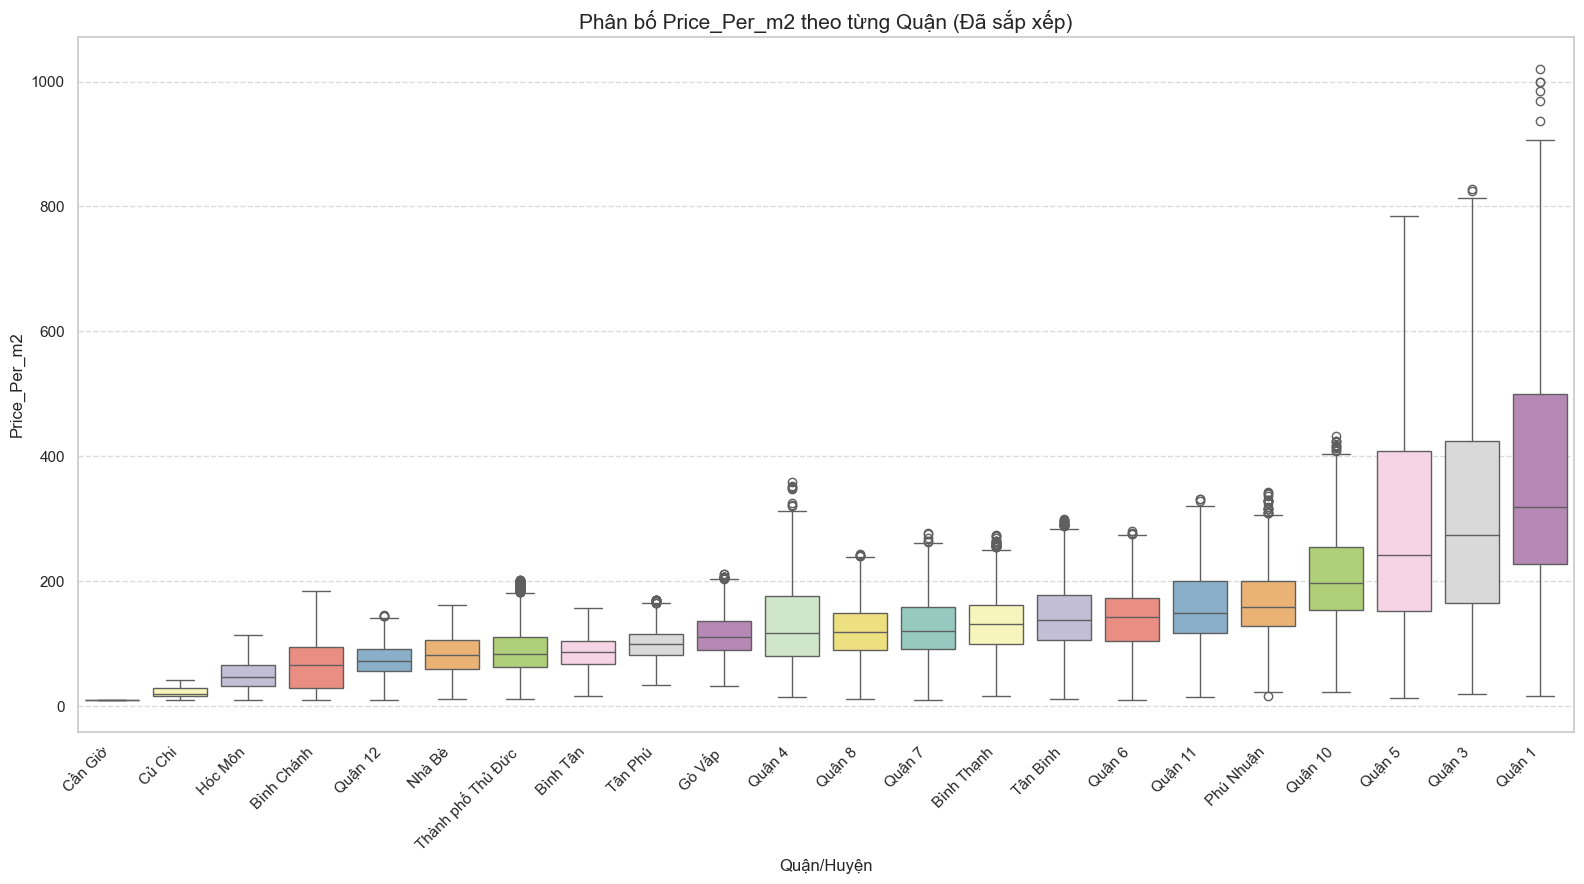

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# File Path
FILE_PATH = '../data/cleaned/Done-EDA.csv'
# Đổi tên file ảnh output để không bị đè lên ảnh cũ, dễ so sánh
OUTPUT_IMG = '../reports/boxplot_price_per_m2_check_after_IQR.png'

def plot_boxplot():
    if not os.path.exists(FILE_PATH):
        print(f"File not found: {FILE_PATH}")
        return

    try:
        # Read Data
        df = pd.read_csv(FILE_PATH)
        print("Columns:", df.columns.tolist())

        # 1. Identify District Column
        col_dist = next((c for c in df.columns if 'district' in c.lower() or 'quan' in c.lower() or 'quận' in c.lower()), None)

        # 2. Identify Price Column - Ưu tiên Price_Per_m2 để check ngoại lai
        # Tìm cột có chữ 'per_m2', 'm2' trong tên giá
        col_price = next((c for c in df.columns if 'price_per' in c.lower() or ('gia' in c.lower() and 'm2' in c.lower())), None)

        # Nếu không có cột m2 mới dùng cột Price_Billion
        if not col_price:
            print("Không tìm thấy cột Price_Per_m2, đang dùng cột Price_Billion...")
            col_price = next((c for c in df.columns if 'price_billion' in c.lower() or 'price_ty' in c.lower()), None)

        if not col_dist or not col_price:
            print(f"Could not identify District ('{col_dist}') or Price ('{col_price}') columns.")
            return

        print(f"Dang ve bieu do: {col_price} theo {col_dist}")

        # Preprocessing
        # Ensure Price is numeric
        df[col_price] = pd.to_numeric(df[col_price], errors='coerce')
        df = df.dropna(subset=[col_price, col_dist])

        # Sắp xếp thứ tự Quận theo giá trung vị (Median) tăng dần để biểu đồ đẹp hơn
        sorted_index = df.groupby(col_dist)[col_price].median().sort_values().index

        # Setup Plot
        plt.figure(figsize=(16, 9)) # Tăng kích thước xíu cho dễ nhìn

        # Vẽ Boxplot với thứ tự đã sắp xếp
        sns.boxplot(x=col_dist, y=col_price, data=df,order=sorted_index, palette="Set3")

        plt.xticks(rotation=45, ha='right')
        plt.title(f'Phân bố {col_price} theo từng Quận (Đã sắp xếp)', fontsize=15)
        plt.ylabel(col_price, fontsize=12)
        plt.xlabel('Quận/Huyện', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7) # Thêm lưới ngang cho dễ dóng
        plt.tight_layout()

        # Save
        plt.savefig(OUTPUT_IMG)
        print(f"Boxplot saved to: {OUTPUT_IMG}")

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    plot_boxplot()

2.1 Exploratory Data Analysis (EDA)

Mục tiêu: chứng minh dữ liệu có cấu trúc và các feature có ý nghĩa

Làm rõ 3 nhóm phân tích:
(A) Distribution

    - Price
    - Price_per_m2
    - Area
    - Bedrooms / Toilets

(B) Relationship với giá

    Area vs Price
    Bedrooms vs Price
    Toilets vs Price
    Floors vs Price
    Is_MatTien vs Price

(C) Theo khu vực

    Median Price_per_m2 theo District
    Variance theo District

--- BẮT ĐẦU VẼ BIỂU ĐỒ EDA CHO BÁO CÁO ---


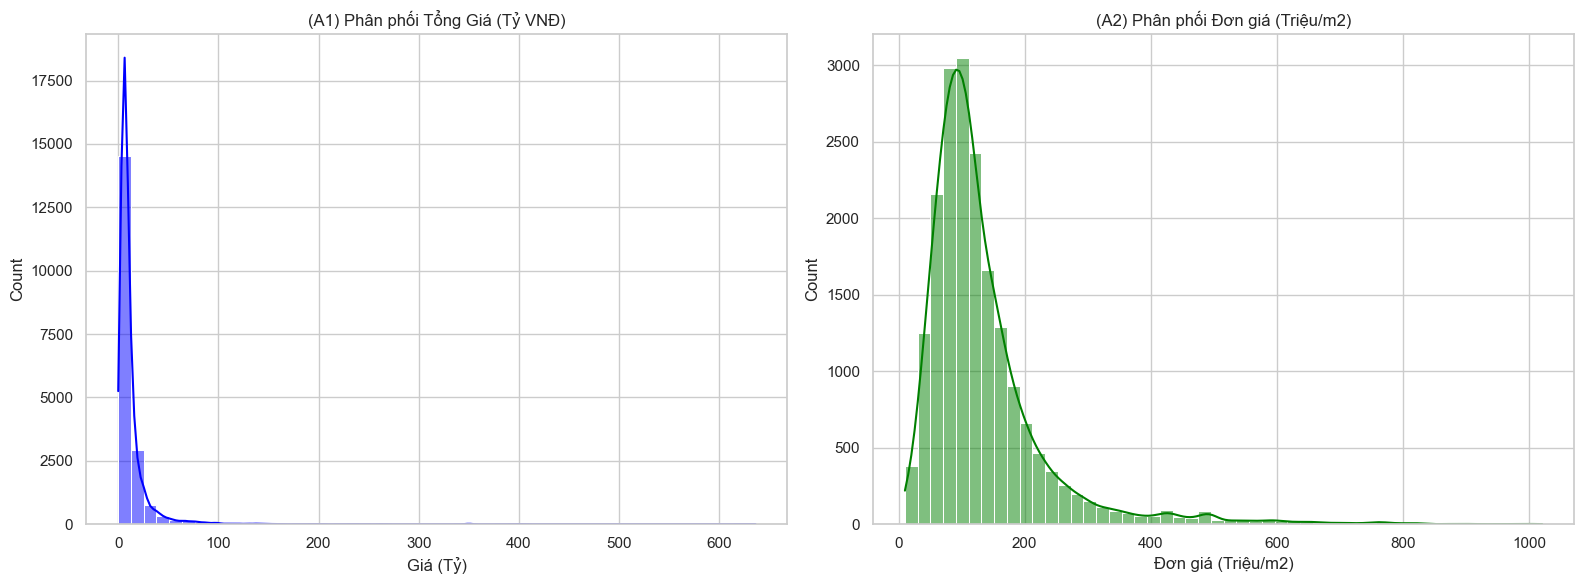

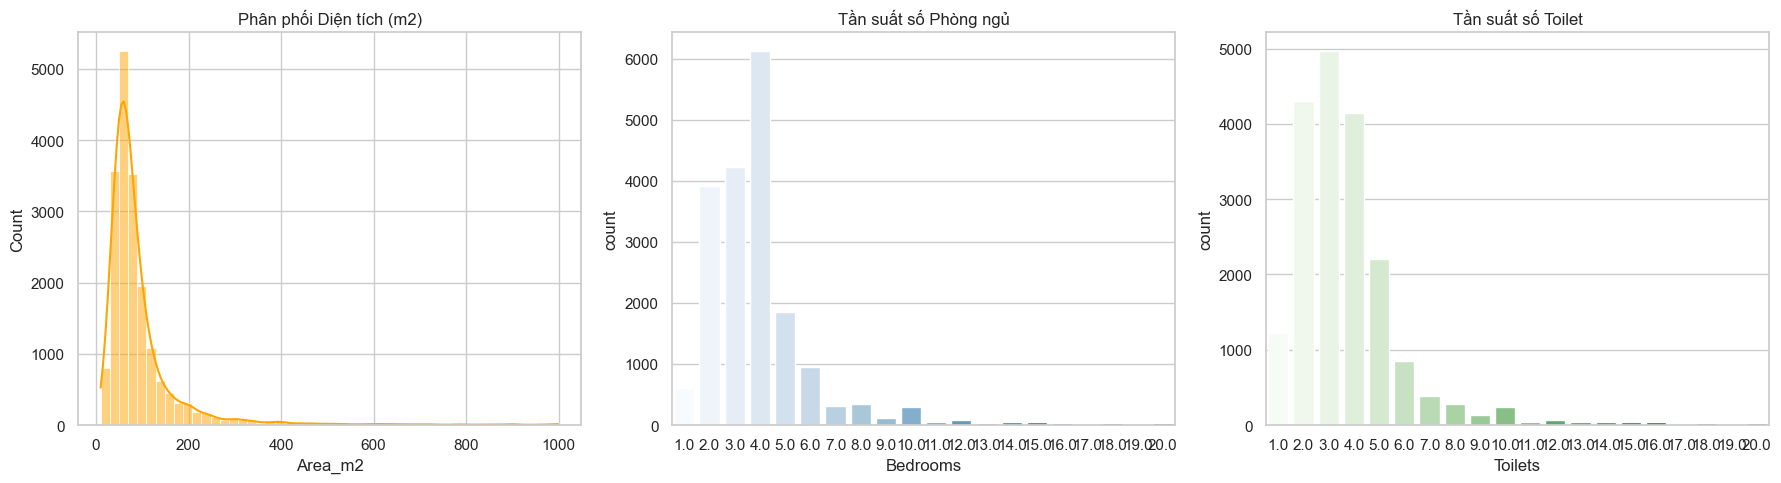

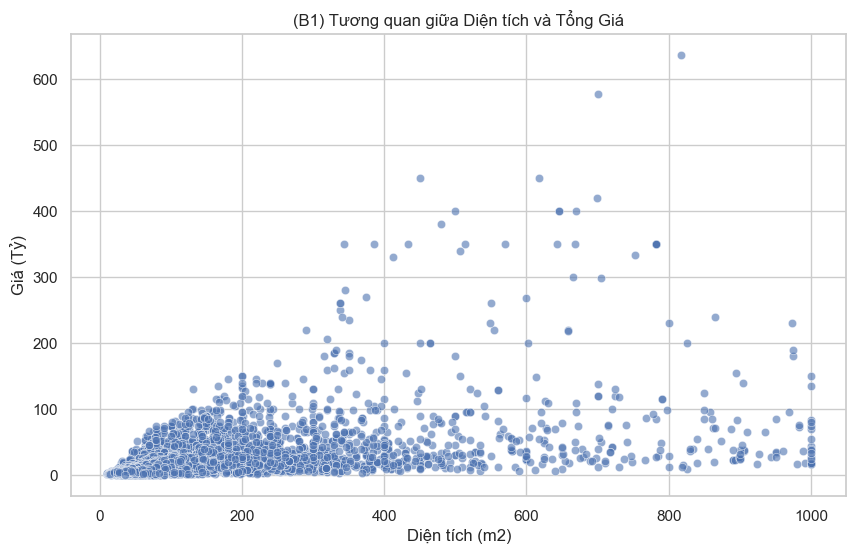

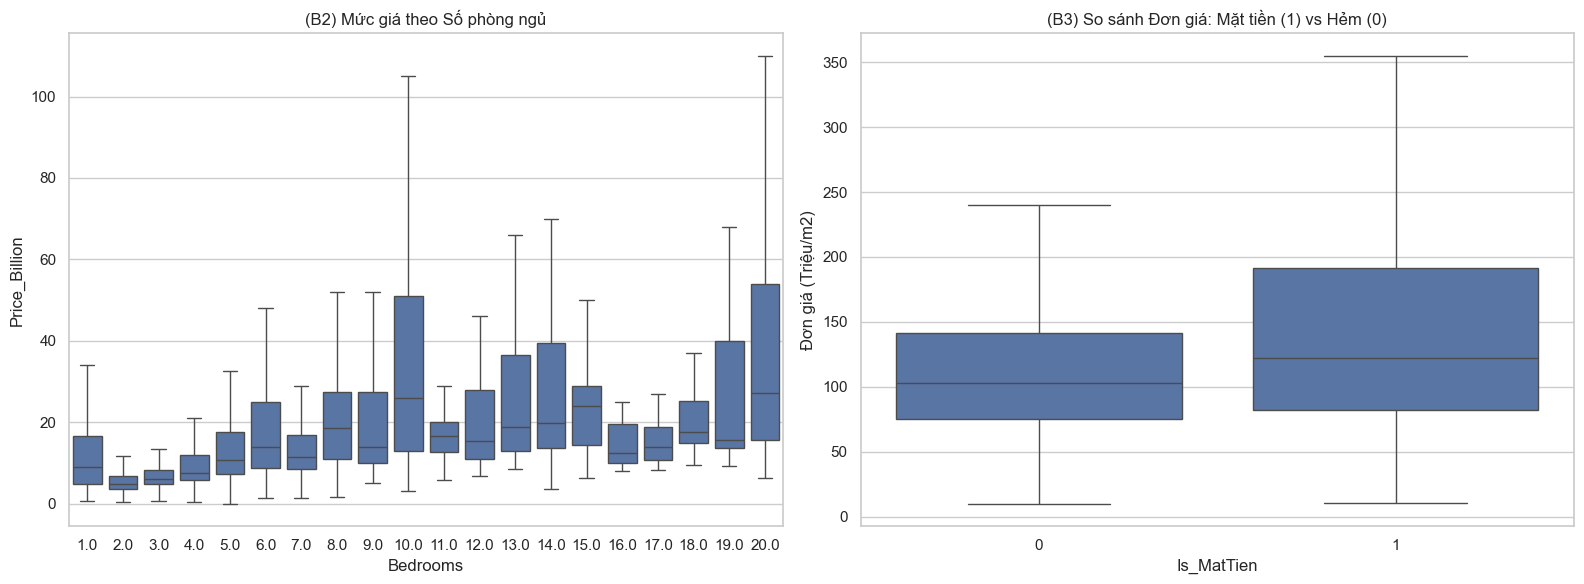

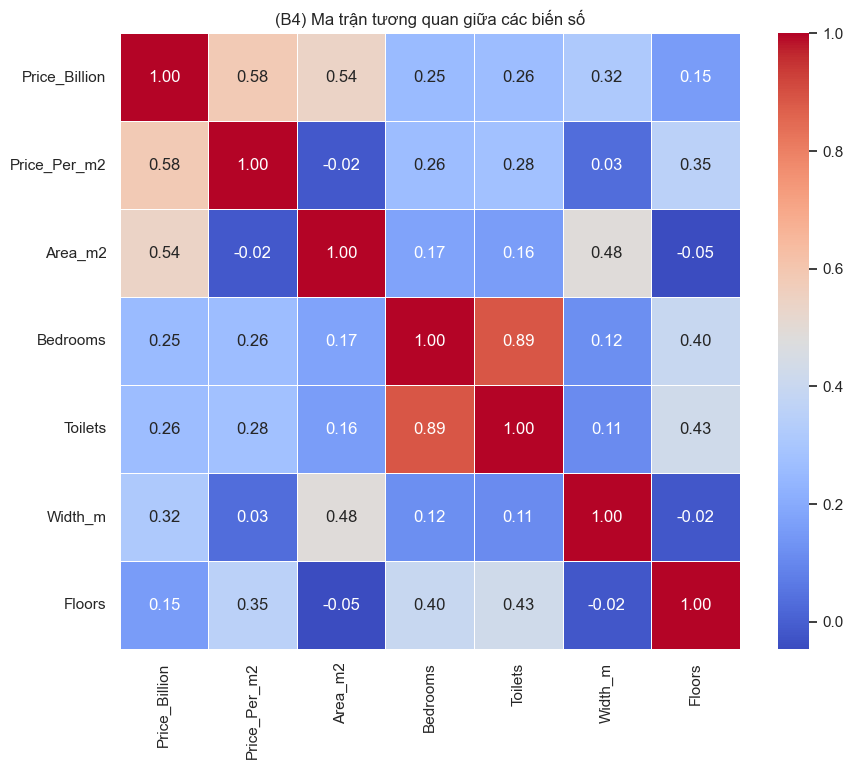

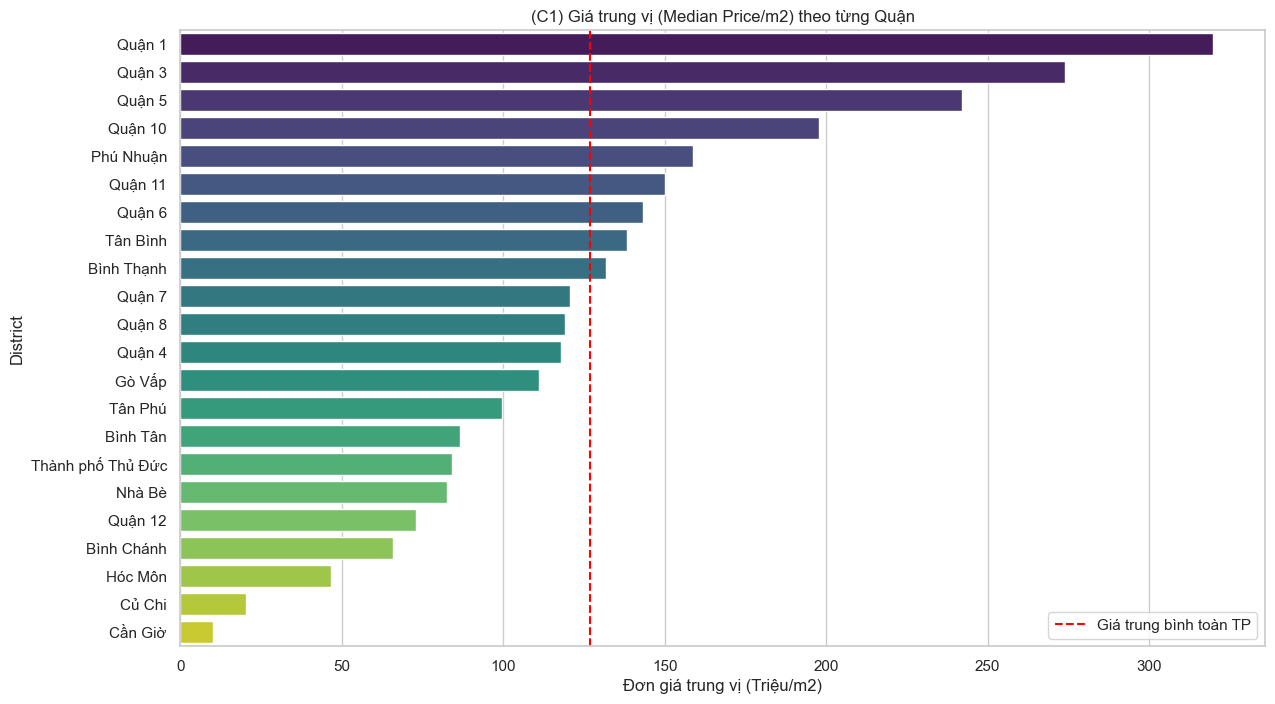

--- ĐÃ VẼ XONG. HÃY LƯU CÁC HÌNH NÀY VÀO BÁO CÁO ---


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Cấu hình giao diện biểu đồ cho báo cáo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

FILE_PATH = '../data/cleaned/Done-EDA.csv'

df = pd.read_csv(FILE_PATH)

print("--- BẮT ĐẦU VẼ BIỂU ĐỒ EDA CHO BÁO CÁO ---")

# ==============================================================================
# NHÓM A: PHÂN PHỐI (DISTRIBUTION)
# ==============================================================================

# A1. Phân phối Giá & Đơn giá
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['Price_Billion'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title('(A1) Phân phối Tổng Giá (Tỷ VNĐ)')
axes[0].set_xlabel('Giá (Tỷ)')

sns.histplot(df['Price_Per_m2'], bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title('(A2) Phân phối Đơn giá (Triệu/m2)')
axes[1].set_xlabel('Đơn giá (Triệu/m2)')

plt.tight_layout()
plt.show()

# A2. Phân phối vật lý
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Area_m2'], bins=50, kde=True, ax=axes[0], color='orange')
axes[0].set_title('Phân phối Diện tích (m2)')

sns.countplot(
    data=df,
    x='Bedrooms',
    hue='Bedrooms',
    palette='Blues',
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Tần suất số Phòng ngủ')

sns.countplot(
    data=df,
    x='Toilets',
    hue='Toilets',
    palette='Greens',
    legend=False,
    ax=axes[2]
)
axes[2].set_title('Tần suất số Toilet')

plt.tight_layout()
plt.show()

# ==============================================================================
# NHÓM B: MỐI QUAN HỆ VỚI GIÁ
# ==============================================================================

# B1. Diện tích vs Giá
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area_m2', y='Price_Billion', alpha=0.6)
plt.title('(B1) Tương quan giữa Diện tích và Tổng Giá')
plt.xlabel('Diện tích (m2)')
plt.ylabel('Giá (Tỷ)')
plt.show()

# B2. Boxplot theo biến rời rạc
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=df,
    x='Bedrooms',
    y='Price_Billion',
    showfliers=False,
    ax=axes[0]
)
axes[0].set_title('(B2) Mức giá theo Số phòng ngủ')

if 'Is_MatTien' in df.columns:
    sns.boxplot(
        data=df,
        x='Is_MatTien',
        y='Price_Per_m2',
        showfliers=False,
        ax=axes[1]
    )
    axes[1].set_title('(B3) So sánh Đơn giá: Mặt tiền (1) vs Hẻm (0)')
    axes[1].set_ylabel('Đơn giá (Triệu/m2)')

plt.tight_layout()
plt.show()

# B3. Heatmap tương quan
cols_corr = ['Price_Billion', 'Price_Per_m2', 'Area_m2', 'Bedrooms', 'Toilets', 'Width_m', 'Floors']
cols_corr = [c for c in cols_corr if c in df.columns]

plt.figure(figsize=(10, 8))
corr_matrix = df[cols_corr].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('(B4) Ma trận tương quan giữa các biến số')
plt.show()

# ==============================================================================
# NHÓM C: PHÂN TÍCH THEO KHU VỰC
# ==============================================================================

median_price = (
    df.groupby('District')['Price_Per_m2']
    .median()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=median_price,
    x='Price_Per_m2',
    y='District',
    hue='District',
    palette='viridis',
    legend=False
)
plt.title('(C1) Giá trung vị (Median Price/m2) theo từng Quận')
plt.xlabel('Đơn giá trung vị (Triệu/m2)')
plt.axvline(
    x=median_price['Price_Per_m2'].mean(),
    color='red',
    linestyle='--',
    label='Giá trung bình toàn TP'
)
plt.legend()
plt.show()

print("--- ĐÃ VẼ XONG. HÃY LƯU CÁC HÌNH NÀY VÀO BÁO CÁO ---")


--- ĐANG TRÍCH XUẤT CHỈ SỐ VÀ VẼ BIỂU ĐỒ ---


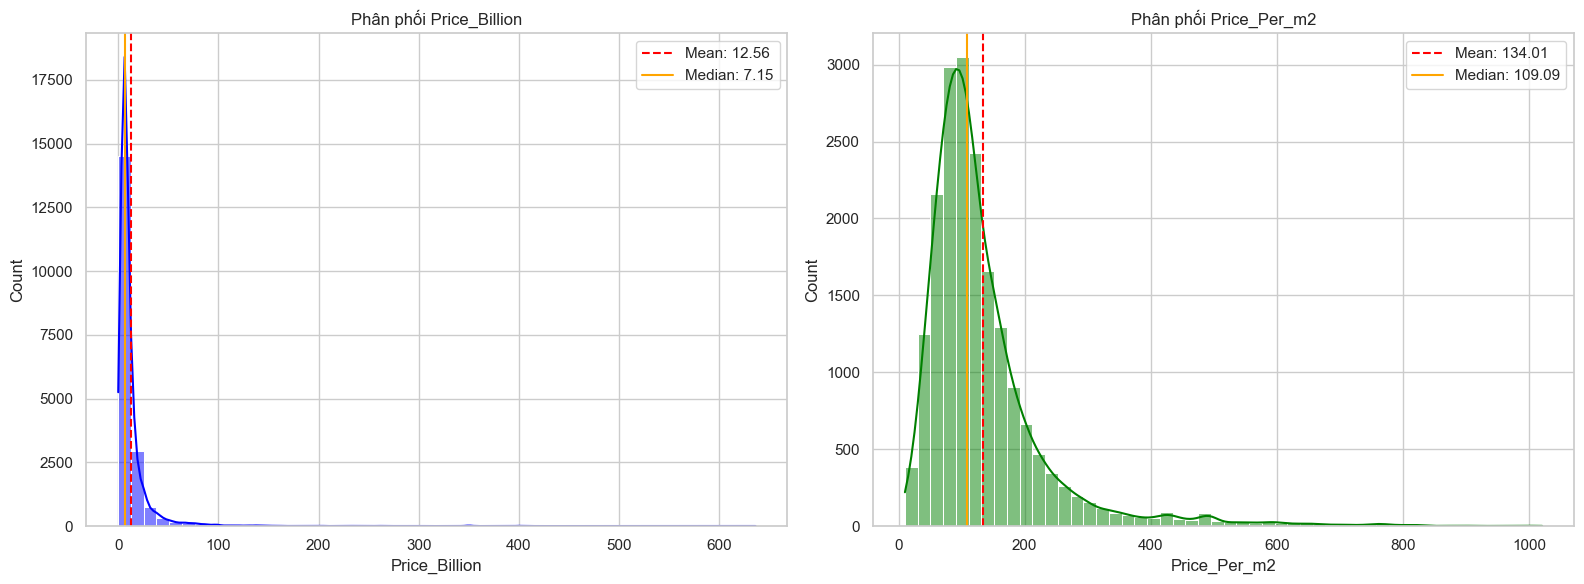

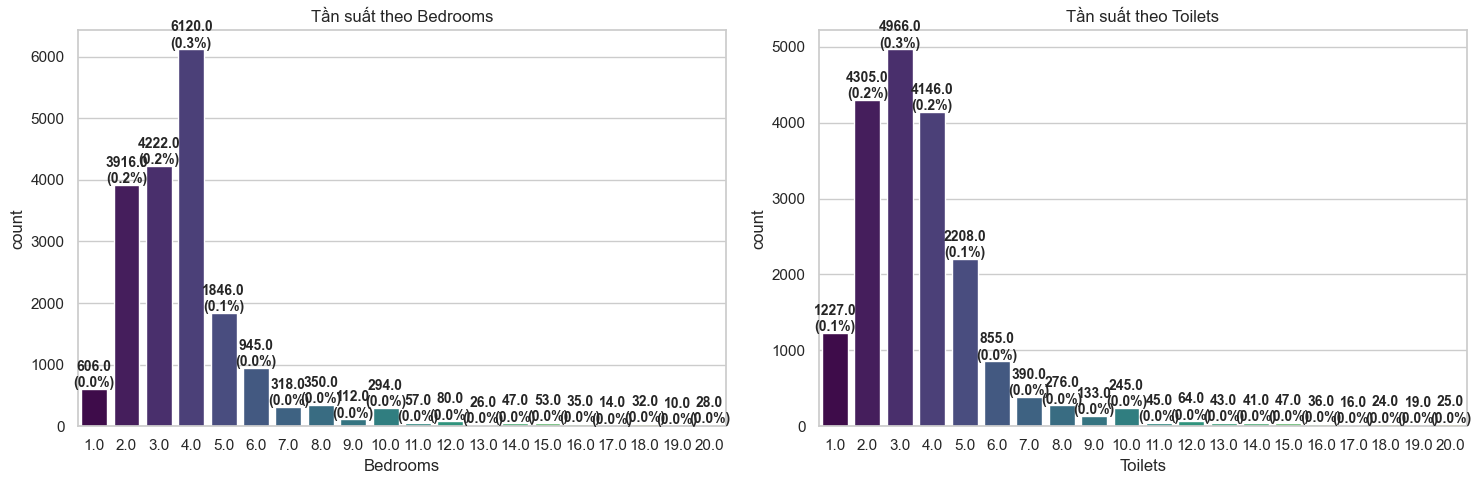

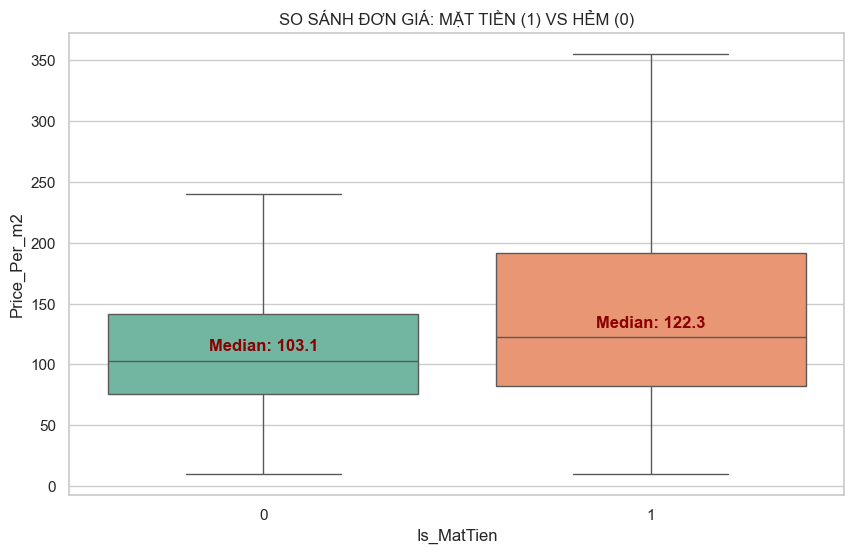

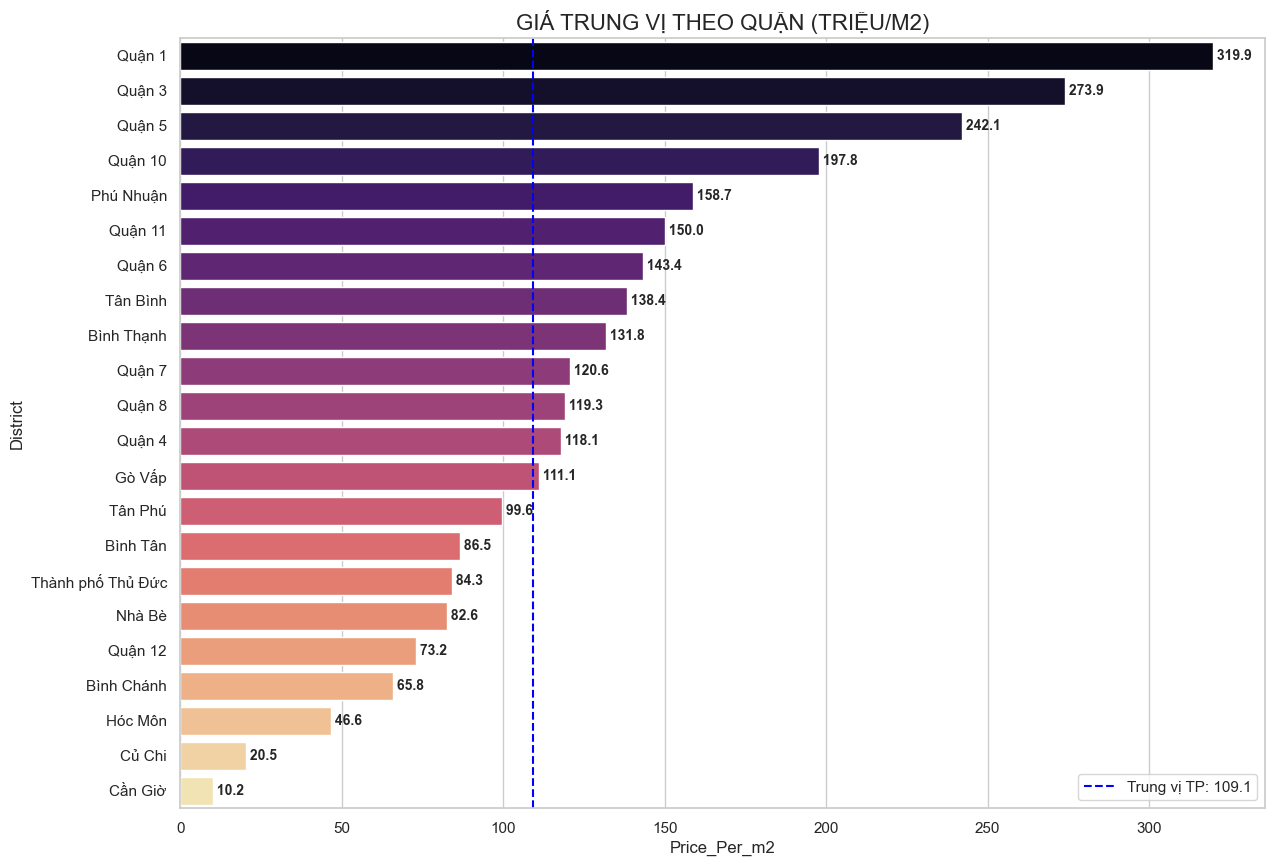

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Cấu hình giao diện
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
FILE_PATH = '../data/cleaned/Done-EDA.csv'
df = pd.read_csv(FILE_PATH)

print("--- ĐANG TRÍCH XUẤT CHỈ SỐ VÀ VẼ BIỂU ĐỒ ---")

# ==============================================================================
# NHÓM A: PHÂN PHỐI & CHỈ SỐ TRUNG TÂM
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
cols = ['Price_Billion', 'Price_Per_m2']
colors = ['blue', 'green']

for i, col in enumerate(cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color=colors[i])
    mean_val = df[col].mean()
    median_val = df[col].median()

    # Vẽ đường Mean và Median
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='orange', linestyle='-', label=f'Median: {median_val:.2f}')
    axes[i].set_title(f'Phân phối {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Biểu đồ đếm số lượng (Bedrooms & Toilets) có hiện %
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, col in enumerate(['Bedrooms', 'Toilets']):
    ax = sns.countplot(data=df, x=col, palette='viridis', ax=axes[i], hue=col, legend=False)
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}\n({height/total:.1f}%)', (p.get_x() + p.get_width()/2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10, fontweight='bold')
    axes[i].set_title(f'Tần suất theo {col}')

plt.tight_layout()
plt.show()

# ==============================================================================
# NHÓM B: SO SÁNH ĐẶC TRƯNG
# ==============================================================================
if 'Is_MatTien' in df.columns:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=df, x='Is_MatTien', y='Price_Per_m2', showfliers=False, palette='Set2', hue='Is_MatTien', legend=False)

    # Tính toán median để hiển thị số trên đầu box
    medians = df.groupby(['Is_MatTien'])['Price_Per_m2'].median().values
    for i, m in enumerate(medians):
        ax.annotate(f'Median: {m:.1f}', xy=(i, m), xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontweight='bold', color='darkred')

    plt.title('SO SÁNH ĐƠN GIÁ: MẶT TIỀN (1) VS HẺM (0)')
    plt.show()

# ==============================================================================
# NHÓM C: CHI TIẾT THEO QUẬN (CỰC KỲ QUAN TRỌNG)
# ==============================================================================
median_price = df.groupby('District')['Price_Per_m2'].median().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 10))
ax = sns.barplot(data=median_price, x='Price_Per_m2', y='District', palette='magma', hue='District', legend=False)

# Ghi số liệu trực tiếp vào cuối mỗi thanh bar
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f' {width:.1f}', (width, p.get_y() + p.get_height()/2.),
                va='center', fontsize=10, fontweight='bold')

# Đường trung bình toàn thành phố
city_median = df['Price_Per_m2'].median()
plt.axvline(city_median, color='blue', linestyle='--', label=f'Trung vị TP: {city_median:.1f}')
plt.title('GIÁ TRUNG VỊ THEO QUẬN (TRIỆU/M2)', fontsize=16)
plt.legend()
plt.show()

In [2]:
print(f"Tổng số bản ghi: {len(df)}")
print(f"Số lượng đặc trưng: {df.shape[1]}")
print(f"Giá nhà thấp nhất: {df['Price_Billion'].min()} Tỷ")
print(f"Giá nhà cao nhất: {df['Price_Billion'].max()} Tỷ")

Tổng số bản ghi: 19111
Số lượng đặc trưng: 12
Giá nhà thấp nhất: 0.009999 Tỷ
Giá nhà cao nhất: 636.0 Tỷ
